## import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## define model architecture

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [3]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [4]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [5]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

## define optimizer and run training epochs

In [6]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [7]:
for epoch in range(1, 20):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.333043
epoch: 1 [320/60000 (1%)]	 training loss: 1.943062
epoch: 1 [640/60000 (1%)]	 training loss: 1.304336
epoch: 1 [960/60000 (2%)]	 training loss: 1.238040
epoch: 1 [1280/60000 (2%)]	 training loss: 0.958737
epoch: 1 [1600/60000 (3%)]	 training loss: 0.493184
epoch: 1 [1920/60000 (3%)]	 training loss: 0.643627
epoch: 1 [2240/60000 (4%)]	 training loss: 0.265545
epoch: 1 [2560/60000 (4%)]	 training loss: 0.560548
epoch: 1 [2880/60000 (5%)]	 training loss: 0.261553
epoch: 1 [3200/60000 (5%)]	 training loss: 0.306239
epoch: 1 [3520/60000 (6%)]	 training loss: 0.300254
epoch: 1 [3840/60000 (6%)]	 training loss: 0.261871
epoch: 1 [4160/60000 (7%)]	 training loss: 0.253512
epoch: 1 [4480/60000 (7%)]	 training loss: 0.103370
epoch: 1 [4800/60000 (8%)]	 training loss: 0.244615
epoch: 1 [5120/60000 (9%)]	 training loss: 0.246581
epoch: 1 [5440/60000 (9%)]	 training loss: 0.426752
epoch: 1 [5760/60000 (10%)]	 training loss: 0.164684
epoch: 1 [6080/60

epoch: 1 [48960/60000 (82%)]	 training loss: 0.189037
epoch: 1 [49280/60000 (82%)]	 training loss: 0.027550
epoch: 1 [49600/60000 (83%)]	 training loss: 0.030760
epoch: 1 [49920/60000 (83%)]	 training loss: 0.047113
epoch: 1 [50240/60000 (84%)]	 training loss: 0.201450
epoch: 1 [50560/60000 (84%)]	 training loss: 0.163309
epoch: 1 [50880/60000 (85%)]	 training loss: 0.230963
epoch: 1 [51200/60000 (85%)]	 training loss: 0.208547
epoch: 1 [51520/60000 (86%)]	 training loss: 0.193209
epoch: 1 [51840/60000 (86%)]	 training loss: 0.052333
epoch: 1 [52160/60000 (87%)]	 training loss: 0.071918
epoch: 1 [52480/60000 (87%)]	 training loss: 0.104872
epoch: 1 [52800/60000 (88%)]	 training loss: 0.100245
epoch: 1 [53120/60000 (89%)]	 training loss: 0.116145
epoch: 1 [53440/60000 (89%)]	 training loss: 0.052742
epoch: 1 [53760/60000 (90%)]	 training loss: 0.207156
epoch: 1 [54080/60000 (90%)]	 training loss: 0.055222
epoch: 1 [54400/60000 (91%)]	 training loss: 0.100362
epoch: 1 [54720/60000 (91%)]

epoch: 2 [37440/60000 (62%)]	 training loss: 0.122305
epoch: 2 [37760/60000 (63%)]	 training loss: 0.145930
epoch: 2 [38080/60000 (63%)]	 training loss: 0.016439
epoch: 2 [38400/60000 (64%)]	 training loss: 0.045070
epoch: 2 [38720/60000 (65%)]	 training loss: 0.018864
epoch: 2 [39040/60000 (65%)]	 training loss: 0.007952
epoch: 2 [39360/60000 (66%)]	 training loss: 0.016014
epoch: 2 [39680/60000 (66%)]	 training loss: 0.068150
epoch: 2 [40000/60000 (67%)]	 training loss: 0.050566
epoch: 2 [40320/60000 (67%)]	 training loss: 0.011531
epoch: 2 [40640/60000 (68%)]	 training loss: 0.005553
epoch: 2 [40960/60000 (68%)]	 training loss: 0.014355
epoch: 2 [41280/60000 (69%)]	 training loss: 0.008815
epoch: 2 [41600/60000 (69%)]	 training loss: 0.008510
epoch: 2 [41920/60000 (70%)]	 training loss: 0.002213
epoch: 2 [42240/60000 (70%)]	 training loss: 0.156662
epoch: 2 [42560/60000 (71%)]	 training loss: 0.224040
epoch: 2 [42880/60000 (71%)]	 training loss: 0.254498
epoch: 2 [43200/60000 (72%)]

epoch: 3 [25920/60000 (43%)]	 training loss: 0.011488
epoch: 3 [26240/60000 (44%)]	 training loss: 0.003887
epoch: 3 [26560/60000 (44%)]	 training loss: 0.315628
epoch: 3 [26880/60000 (45%)]	 training loss: 0.147676
epoch: 3 [27200/60000 (45%)]	 training loss: 0.006523
epoch: 3 [27520/60000 (46%)]	 training loss: 0.032355
epoch: 3 [27840/60000 (46%)]	 training loss: 0.162399
epoch: 3 [28160/60000 (47%)]	 training loss: 0.000650
epoch: 3 [28480/60000 (47%)]	 training loss: 0.060941
epoch: 3 [28800/60000 (48%)]	 training loss: 0.049059
epoch: 3 [29120/60000 (49%)]	 training loss: 0.011951
epoch: 3 [29440/60000 (49%)]	 training loss: 0.007248
epoch: 3 [29760/60000 (50%)]	 training loss: 0.032459
epoch: 3 [30080/60000 (50%)]	 training loss: 0.001153
epoch: 3 [30400/60000 (51%)]	 training loss: 0.001172
epoch: 3 [30720/60000 (51%)]	 training loss: 0.075565
epoch: 3 [31040/60000 (52%)]	 training loss: 0.022946
epoch: 3 [31360/60000 (52%)]	 training loss: 0.005423
epoch: 3 [31680/60000 (53%)]

epoch: 4 [14400/60000 (24%)]	 training loss: 0.001610
epoch: 4 [14720/60000 (25%)]	 training loss: 0.070175
epoch: 4 [15040/60000 (25%)]	 training loss: 0.013863
epoch: 4 [15360/60000 (26%)]	 training loss: 0.012433
epoch: 4 [15680/60000 (26%)]	 training loss: 0.158234
epoch: 4 [16000/60000 (27%)]	 training loss: 0.002333
epoch: 4 [16320/60000 (27%)]	 training loss: 0.005482
epoch: 4 [16640/60000 (28%)]	 training loss: 0.001946
epoch: 4 [16960/60000 (28%)]	 training loss: 0.047215
epoch: 4 [17280/60000 (29%)]	 training loss: 0.019467
epoch: 4 [17600/60000 (29%)]	 training loss: 0.075563
epoch: 4 [17920/60000 (30%)]	 training loss: 0.035971
epoch: 4 [18240/60000 (30%)]	 training loss: 0.002394
epoch: 4 [18560/60000 (31%)]	 training loss: 0.001120
epoch: 4 [18880/60000 (31%)]	 training loss: 0.025516
epoch: 4 [19200/60000 (32%)]	 training loss: 0.077274
epoch: 4 [19520/60000 (33%)]	 training loss: 0.294797
epoch: 4 [19840/60000 (33%)]	 training loss: 0.010043
epoch: 4 [20160/60000 (34%)]

epoch: 5 [2560/60000 (4%)]	 training loss: 0.001106
epoch: 5 [2880/60000 (5%)]	 training loss: 0.006430
epoch: 5 [3200/60000 (5%)]	 training loss: 0.006645
epoch: 5 [3520/60000 (6%)]	 training loss: 0.064642
epoch: 5 [3840/60000 (6%)]	 training loss: 0.000591
epoch: 5 [4160/60000 (7%)]	 training loss: 0.006640
epoch: 5 [4480/60000 (7%)]	 training loss: 0.021118
epoch: 5 [4800/60000 (8%)]	 training loss: 0.009449
epoch: 5 [5120/60000 (9%)]	 training loss: 0.011730
epoch: 5 [5440/60000 (9%)]	 training loss: 0.001851
epoch: 5 [5760/60000 (10%)]	 training loss: 0.114151
epoch: 5 [6080/60000 (10%)]	 training loss: 0.040879
epoch: 5 [6400/60000 (11%)]	 training loss: 0.038032
epoch: 5 [6720/60000 (11%)]	 training loss: 0.005098
epoch: 5 [7040/60000 (12%)]	 training loss: 0.078207
epoch: 5 [7360/60000 (12%)]	 training loss: 0.005355
epoch: 5 [7680/60000 (13%)]	 training loss: 0.002868
epoch: 5 [8000/60000 (13%)]	 training loss: 0.012961
epoch: 5 [8320/60000 (14%)]	 training loss: 0.072866
epo

epoch: 5 [51520/60000 (86%)]	 training loss: 0.001317
epoch: 5 [51840/60000 (86%)]	 training loss: 0.095925
epoch: 5 [52160/60000 (87%)]	 training loss: 0.004173
epoch: 5 [52480/60000 (87%)]	 training loss: 0.001185
epoch: 5 [52800/60000 (88%)]	 training loss: 0.003036
epoch: 5 [53120/60000 (89%)]	 training loss: 0.021657
epoch: 5 [53440/60000 (89%)]	 training loss: 0.000199
epoch: 5 [53760/60000 (90%)]	 training loss: 0.001553
epoch: 5 [54080/60000 (90%)]	 training loss: 0.013963
epoch: 5 [54400/60000 (91%)]	 training loss: 0.020786
epoch: 5 [54720/60000 (91%)]	 training loss: 0.008905
epoch: 5 [55040/60000 (92%)]	 training loss: 0.039044
epoch: 5 [55360/60000 (92%)]	 training loss: 0.062111
epoch: 5 [55680/60000 (93%)]	 training loss: 0.044069
epoch: 5 [56000/60000 (93%)]	 training loss: 0.293081
epoch: 5 [56320/60000 (94%)]	 training loss: 0.001521
epoch: 5 [56640/60000 (94%)]	 training loss: 0.044059
epoch: 5 [56960/60000 (95%)]	 training loss: 0.002164
epoch: 5 [57280/60000 (95%)]

epoch: 6 [40000/60000 (67%)]	 training loss: 0.000179
epoch: 6 [40320/60000 (67%)]	 training loss: 0.000553
epoch: 6 [40640/60000 (68%)]	 training loss: 0.003415
epoch: 6 [40960/60000 (68%)]	 training loss: 0.002057
epoch: 6 [41280/60000 (69%)]	 training loss: 0.000112
epoch: 6 [41600/60000 (69%)]	 training loss: 0.012264
epoch: 6 [41920/60000 (70%)]	 training loss: 0.000271
epoch: 6 [42240/60000 (70%)]	 training loss: 0.025492
epoch: 6 [42560/60000 (71%)]	 training loss: 0.039831
epoch: 6 [42880/60000 (71%)]	 training loss: 0.034893
epoch: 6 [43200/60000 (72%)]	 training loss: 0.029071
epoch: 6 [43520/60000 (73%)]	 training loss: 0.000352
epoch: 6 [43840/60000 (73%)]	 training loss: 0.004263
epoch: 6 [44160/60000 (74%)]	 training loss: 0.013897
epoch: 6 [44480/60000 (74%)]	 training loss: 0.073374
epoch: 6 [44800/60000 (75%)]	 training loss: 0.013917
epoch: 6 [45120/60000 (75%)]	 training loss: 0.112081
epoch: 6 [45440/60000 (76%)]	 training loss: 0.002833
epoch: 6 [45760/60000 (76%)]

epoch: 7 [28480/60000 (47%)]	 training loss: 0.000587
epoch: 7 [28800/60000 (48%)]	 training loss: 0.036599
epoch: 7 [29120/60000 (49%)]	 training loss: 0.002834
epoch: 7 [29440/60000 (49%)]	 training loss: 0.148385
epoch: 7 [29760/60000 (50%)]	 training loss: 0.004178
epoch: 7 [30080/60000 (50%)]	 training loss: 0.006388
epoch: 7 [30400/60000 (51%)]	 training loss: 0.001270
epoch: 7 [30720/60000 (51%)]	 training loss: 0.001692
epoch: 7 [31040/60000 (52%)]	 training loss: 0.041071
epoch: 7 [31360/60000 (52%)]	 training loss: 0.329523
epoch: 7 [31680/60000 (53%)]	 training loss: 0.000068
epoch: 7 [32000/60000 (53%)]	 training loss: 0.010583
epoch: 7 [32320/60000 (54%)]	 training loss: 0.199859
epoch: 7 [32640/60000 (54%)]	 training loss: 0.000986
epoch: 7 [32960/60000 (55%)]	 training loss: 0.038600
epoch: 7 [33280/60000 (55%)]	 training loss: 0.005068
epoch: 7 [33600/60000 (56%)]	 training loss: 0.000119
epoch: 7 [33920/60000 (57%)]	 training loss: 0.078540
epoch: 7 [34240/60000 (57%)]

epoch: 8 [16960/60000 (28%)]	 training loss: 0.018272
epoch: 8 [17280/60000 (29%)]	 training loss: 0.021515
epoch: 8 [17600/60000 (29%)]	 training loss: 0.087931
epoch: 8 [17920/60000 (30%)]	 training loss: 0.009689
epoch: 8 [18240/60000 (30%)]	 training loss: 0.008298
epoch: 8 [18560/60000 (31%)]	 training loss: 0.190545
epoch: 8 [18880/60000 (31%)]	 training loss: 0.317700
epoch: 8 [19200/60000 (32%)]	 training loss: 0.003710
epoch: 8 [19520/60000 (33%)]	 training loss: 0.014792
epoch: 8 [19840/60000 (33%)]	 training loss: 0.001124
epoch: 8 [20160/60000 (34%)]	 training loss: 0.002587
epoch: 8 [20480/60000 (34%)]	 training loss: 0.012084
epoch: 8 [20800/60000 (35%)]	 training loss: 0.038801
epoch: 8 [21120/60000 (35%)]	 training loss: 0.000152
epoch: 8 [21440/60000 (36%)]	 training loss: 0.070894
epoch: 8 [21760/60000 (36%)]	 training loss: 0.084773
epoch: 8 [22080/60000 (37%)]	 training loss: 0.030737
epoch: 8 [22400/60000 (37%)]	 training loss: 0.003192
epoch: 8 [22720/60000 (38%)]

epoch: 9 [5440/60000 (9%)]	 training loss: 0.058256
epoch: 9 [5760/60000 (10%)]	 training loss: 0.001104
epoch: 9 [6080/60000 (10%)]	 training loss: 0.007344
epoch: 9 [6400/60000 (11%)]	 training loss: 0.068893
epoch: 9 [6720/60000 (11%)]	 training loss: 0.026050
epoch: 9 [7040/60000 (12%)]	 training loss: 0.006308
epoch: 9 [7360/60000 (12%)]	 training loss: 0.001014
epoch: 9 [7680/60000 (13%)]	 training loss: 0.278803
epoch: 9 [8000/60000 (13%)]	 training loss: 0.003600
epoch: 9 [8320/60000 (14%)]	 training loss: 0.001685
epoch: 9 [8640/60000 (14%)]	 training loss: 0.000868
epoch: 9 [8960/60000 (15%)]	 training loss: 0.003480
epoch: 9 [9280/60000 (15%)]	 training loss: 0.000139
epoch: 9 [9600/60000 (16%)]	 training loss: 0.003940
epoch: 9 [9920/60000 (17%)]	 training loss: 0.042228
epoch: 9 [10240/60000 (17%)]	 training loss: 0.002606
epoch: 9 [10560/60000 (18%)]	 training loss: 0.123327
epoch: 9 [10880/60000 (18%)]	 training loss: 0.004359
epoch: 9 [11200/60000 (19%)]	 training loss:

epoch: 9 [54400/60000 (91%)]	 training loss: 0.000195
epoch: 9 [54720/60000 (91%)]	 training loss: 0.000131
epoch: 9 [55040/60000 (92%)]	 training loss: 0.007233
epoch: 9 [55360/60000 (92%)]	 training loss: 0.027878
epoch: 9 [55680/60000 (93%)]	 training loss: 0.002412
epoch: 9 [56000/60000 (93%)]	 training loss: 0.003024
epoch: 9 [56320/60000 (94%)]	 training loss: 0.000203
epoch: 9 [56640/60000 (94%)]	 training loss: 0.001753
epoch: 9 [56960/60000 (95%)]	 training loss: 0.001031
epoch: 9 [57280/60000 (95%)]	 training loss: 0.002708
epoch: 9 [57600/60000 (96%)]	 training loss: 0.066091
epoch: 9 [57920/60000 (97%)]	 training loss: 0.000020
epoch: 9 [58240/60000 (97%)]	 training loss: 0.008144
epoch: 9 [58560/60000 (98%)]	 training loss: 0.012474
epoch: 9 [58880/60000 (98%)]	 training loss: 0.009536
epoch: 9 [59200/60000 (99%)]	 training loss: 0.048553
epoch: 9 [59520/60000 (99%)]	 training loss: 0.072044
epoch: 9 [59840/60000 (100%)]	 training loss: 0.047149

Test dataset: Overall Loss

epoch: 10 [41920/60000 (70%)]	 training loss: 0.000205
epoch: 10 [42240/60000 (70%)]	 training loss: 0.002017
epoch: 10 [42560/60000 (71%)]	 training loss: 0.022898
epoch: 10 [42880/60000 (71%)]	 training loss: 0.065059
epoch: 10 [43200/60000 (72%)]	 training loss: 0.000336
epoch: 10 [43520/60000 (73%)]	 training loss: 0.006003
epoch: 10 [43840/60000 (73%)]	 training loss: 0.003943
epoch: 10 [44160/60000 (74%)]	 training loss: 0.010917
epoch: 10 [44480/60000 (74%)]	 training loss: 0.006168
epoch: 10 [44800/60000 (75%)]	 training loss: 0.002572
epoch: 10 [45120/60000 (75%)]	 training loss: 0.022804
epoch: 10 [45440/60000 (76%)]	 training loss: 0.001737
epoch: 10 [45760/60000 (76%)]	 training loss: 0.057166
epoch: 10 [46080/60000 (77%)]	 training loss: 0.001228
epoch: 10 [46400/60000 (77%)]	 training loss: 0.046815
epoch: 10 [46720/60000 (78%)]	 training loss: 0.002258
epoch: 10 [47040/60000 (78%)]	 training loss: 0.001428
epoch: 10 [47360/60000 (79%)]	 training loss: 0.046284
epoch: 10 

epoch: 11 [29440/60000 (49%)]	 training loss: 0.019088
epoch: 11 [29760/60000 (50%)]	 training loss: 0.153378
epoch: 11 [30080/60000 (50%)]	 training loss: 0.035859
epoch: 11 [30400/60000 (51%)]	 training loss: 0.002414
epoch: 11 [30720/60000 (51%)]	 training loss: 0.011015
epoch: 11 [31040/60000 (52%)]	 training loss: 0.000301
epoch: 11 [31360/60000 (52%)]	 training loss: 0.089588
epoch: 11 [31680/60000 (53%)]	 training loss: 0.035275
epoch: 11 [32000/60000 (53%)]	 training loss: 0.013083
epoch: 11 [32320/60000 (54%)]	 training loss: 0.199120
epoch: 11 [32640/60000 (54%)]	 training loss: 0.005549
epoch: 11 [32960/60000 (55%)]	 training loss: 0.006944
epoch: 11 [33280/60000 (55%)]	 training loss: 0.000013
epoch: 11 [33600/60000 (56%)]	 training loss: 0.010285
epoch: 11 [33920/60000 (57%)]	 training loss: 0.000377
epoch: 11 [34240/60000 (57%)]	 training loss: 0.044127
epoch: 11 [34560/60000 (58%)]	 training loss: 0.007240
epoch: 11 [34880/60000 (58%)]	 training loss: 0.065524
epoch: 11 

epoch: 12 [16960/60000 (28%)]	 training loss: 0.038294
epoch: 12 [17280/60000 (29%)]	 training loss: 0.003550
epoch: 12 [17600/60000 (29%)]	 training loss: 0.001535
epoch: 12 [17920/60000 (30%)]	 training loss: 0.001515
epoch: 12 [18240/60000 (30%)]	 training loss: 0.001292
epoch: 12 [18560/60000 (31%)]	 training loss: 0.000542
epoch: 12 [18880/60000 (31%)]	 training loss: 0.000178
epoch: 12 [19200/60000 (32%)]	 training loss: 0.000172
epoch: 12 [19520/60000 (33%)]	 training loss: 0.000380
epoch: 12 [19840/60000 (33%)]	 training loss: 0.086875
epoch: 12 [20160/60000 (34%)]	 training loss: 0.000794
epoch: 12 [20480/60000 (34%)]	 training loss: 0.001335
epoch: 12 [20800/60000 (35%)]	 training loss: 0.027173
epoch: 12 [21120/60000 (35%)]	 training loss: 0.070624
epoch: 12 [21440/60000 (36%)]	 training loss: 0.000093
epoch: 12 [21760/60000 (36%)]	 training loss: 0.000063
epoch: 12 [22080/60000 (37%)]	 training loss: 0.002238
epoch: 12 [22400/60000 (37%)]	 training loss: 0.002341
epoch: 12 

epoch: 13 [4480/60000 (7%)]	 training loss: 0.000627
epoch: 13 [4800/60000 (8%)]	 training loss: 0.014556
epoch: 13 [5120/60000 (9%)]	 training loss: 0.089599
epoch: 13 [5440/60000 (9%)]	 training loss: 0.020654
epoch: 13 [5760/60000 (10%)]	 training loss: 0.007298
epoch: 13 [6080/60000 (10%)]	 training loss: 0.140368
epoch: 13 [6400/60000 (11%)]	 training loss: 0.000063
epoch: 13 [6720/60000 (11%)]	 training loss: 0.049608
epoch: 13 [7040/60000 (12%)]	 training loss: 0.003712
epoch: 13 [7360/60000 (12%)]	 training loss: 0.000072
epoch: 13 [7680/60000 (13%)]	 training loss: 0.406564
epoch: 13 [8000/60000 (13%)]	 training loss: 0.003493
epoch: 13 [8320/60000 (14%)]	 training loss: 0.010952
epoch: 13 [8640/60000 (14%)]	 training loss: 0.122486
epoch: 13 [8960/60000 (15%)]	 training loss: 0.009045
epoch: 13 [9280/60000 (15%)]	 training loss: 0.034399
epoch: 13 [9600/60000 (16%)]	 training loss: 0.040408
epoch: 13 [9920/60000 (17%)]	 training loss: 0.000085
epoch: 13 [10240/60000 (17%)]	 t

epoch: 13 [52480/60000 (87%)]	 training loss: 0.000764
epoch: 13 [52800/60000 (88%)]	 training loss: 0.000017
epoch: 13 [53120/60000 (89%)]	 training loss: 0.001306
epoch: 13 [53440/60000 (89%)]	 training loss: 0.021752
epoch: 13 [53760/60000 (90%)]	 training loss: 0.001519
epoch: 13 [54080/60000 (90%)]	 training loss: 0.000116
epoch: 13 [54400/60000 (91%)]	 training loss: 0.000177
epoch: 13 [54720/60000 (91%)]	 training loss: 0.000200
epoch: 13 [55040/60000 (92%)]	 training loss: 0.006733
epoch: 13 [55360/60000 (92%)]	 training loss: 0.006740
epoch: 13 [55680/60000 (93%)]	 training loss: 0.050465
epoch: 13 [56000/60000 (93%)]	 training loss: 0.006101
epoch: 13 [56320/60000 (94%)]	 training loss: 0.004351
epoch: 13 [56640/60000 (94%)]	 training loss: 0.000011
epoch: 13 [56960/60000 (95%)]	 training loss: 0.000341
epoch: 13 [57280/60000 (95%)]	 training loss: 0.002264
epoch: 13 [57600/60000 (96%)]	 training loss: 0.003785
epoch: 13 [57920/60000 (97%)]	 training loss: 0.000405
epoch: 13 

epoch: 14 [40000/60000 (67%)]	 training loss: 0.002122
epoch: 14 [40320/60000 (67%)]	 training loss: 0.005684
epoch: 14 [40640/60000 (68%)]	 training loss: 0.000799
epoch: 14 [40960/60000 (68%)]	 training loss: 0.003873
epoch: 14 [41280/60000 (69%)]	 training loss: 0.001122
epoch: 14 [41600/60000 (69%)]	 training loss: 0.023078
epoch: 14 [41920/60000 (70%)]	 training loss: 0.007158
epoch: 14 [42240/60000 (70%)]	 training loss: 0.000219
epoch: 14 [42560/60000 (71%)]	 training loss: 0.001506
epoch: 14 [42880/60000 (71%)]	 training loss: 0.000932
epoch: 14 [43200/60000 (72%)]	 training loss: 0.000450
epoch: 14 [43520/60000 (73%)]	 training loss: 0.002113
epoch: 14 [43840/60000 (73%)]	 training loss: 0.002615
epoch: 14 [44160/60000 (74%)]	 training loss: 0.002657
epoch: 14 [44480/60000 (74%)]	 training loss: 0.090202
epoch: 14 [44800/60000 (75%)]	 training loss: 0.000002
epoch: 14 [45120/60000 (75%)]	 training loss: 0.078418
epoch: 14 [45440/60000 (76%)]	 training loss: 0.011661
epoch: 14 

epoch: 15 [27520/60000 (46%)]	 training loss: 0.000653
epoch: 15 [27840/60000 (46%)]	 training loss: 0.000016
epoch: 15 [28160/60000 (47%)]	 training loss: 0.018881
epoch: 15 [28480/60000 (47%)]	 training loss: 0.038367
epoch: 15 [28800/60000 (48%)]	 training loss: 0.000067
epoch: 15 [29120/60000 (49%)]	 training loss: 0.001267
epoch: 15 [29440/60000 (49%)]	 training loss: 0.123102
epoch: 15 [29760/60000 (50%)]	 training loss: 0.005644
epoch: 15 [30080/60000 (50%)]	 training loss: 0.002502
epoch: 15 [30400/60000 (51%)]	 training loss: 0.000081
epoch: 15 [30720/60000 (51%)]	 training loss: 0.000623
epoch: 15 [31040/60000 (52%)]	 training loss: 0.035079
epoch: 15 [31360/60000 (52%)]	 training loss: 0.016611
epoch: 15 [31680/60000 (53%)]	 training loss: 0.139136
epoch: 15 [32000/60000 (53%)]	 training loss: 0.000268
epoch: 15 [32320/60000 (54%)]	 training loss: 0.002709
epoch: 15 [32640/60000 (54%)]	 training loss: 0.005341
epoch: 15 [32960/60000 (55%)]	 training loss: 0.000902
epoch: 15 

epoch: 16 [15040/60000 (25%)]	 training loss: 0.000004
epoch: 16 [15360/60000 (26%)]	 training loss: 0.000012
epoch: 16 [15680/60000 (26%)]	 training loss: 0.000533
epoch: 16 [16000/60000 (27%)]	 training loss: 0.000123
epoch: 16 [16320/60000 (27%)]	 training loss: 0.005864
epoch: 16 [16640/60000 (28%)]	 training loss: 0.017874
epoch: 16 [16960/60000 (28%)]	 training loss: 0.001386
epoch: 16 [17280/60000 (29%)]	 training loss: 0.000154
epoch: 16 [17600/60000 (29%)]	 training loss: 0.000004
epoch: 16 [17920/60000 (30%)]	 training loss: 0.045544
epoch: 16 [18240/60000 (30%)]	 training loss: 0.000676
epoch: 16 [18560/60000 (31%)]	 training loss: 0.000084
epoch: 16 [18880/60000 (31%)]	 training loss: 0.004694
epoch: 16 [19200/60000 (32%)]	 training loss: 0.005859
epoch: 16 [19520/60000 (33%)]	 training loss: 0.000213
epoch: 16 [19840/60000 (33%)]	 training loss: 0.059978
epoch: 16 [20160/60000 (34%)]	 training loss: 0.042538
epoch: 16 [20480/60000 (34%)]	 training loss: 0.000017
epoch: 16 

epoch: 17 [2240/60000 (4%)]	 training loss: 0.000190
epoch: 17 [2560/60000 (4%)]	 training loss: 0.007022
epoch: 17 [2880/60000 (5%)]	 training loss: 0.000026
epoch: 17 [3200/60000 (5%)]	 training loss: 0.000299
epoch: 17 [3520/60000 (6%)]	 training loss: 0.000126
epoch: 17 [3840/60000 (6%)]	 training loss: 0.000817
epoch: 17 [4160/60000 (7%)]	 training loss: 0.000894
epoch: 17 [4480/60000 (7%)]	 training loss: 0.002803
epoch: 17 [4800/60000 (8%)]	 training loss: 0.034422
epoch: 17 [5120/60000 (9%)]	 training loss: 0.003799
epoch: 17 [5440/60000 (9%)]	 training loss: 0.000050
epoch: 17 [5760/60000 (10%)]	 training loss: 0.003492
epoch: 17 [6080/60000 (10%)]	 training loss: 0.000001
epoch: 17 [6400/60000 (11%)]	 training loss: 0.002048
epoch: 17 [6720/60000 (11%)]	 training loss: 0.010294
epoch: 17 [7040/60000 (12%)]	 training loss: 0.000027
epoch: 17 [7360/60000 (12%)]	 training loss: 0.002072
epoch: 17 [7680/60000 (13%)]	 training loss: 0.001444
epoch: 17 [8000/60000 (13%)]	 training 

epoch: 17 [50240/60000 (84%)]	 training loss: 0.008073
epoch: 17 [50560/60000 (84%)]	 training loss: 0.000376
epoch: 17 [50880/60000 (85%)]	 training loss: 0.000269
epoch: 17 [51200/60000 (85%)]	 training loss: 0.000007
epoch: 17 [51520/60000 (86%)]	 training loss: 0.000055
epoch: 17 [51840/60000 (86%)]	 training loss: 0.000624
epoch: 17 [52160/60000 (87%)]	 training loss: 0.003861
epoch: 17 [52480/60000 (87%)]	 training loss: 0.000017
epoch: 17 [52800/60000 (88%)]	 training loss: 0.008456
epoch: 17 [53120/60000 (89%)]	 training loss: 0.000028
epoch: 17 [53440/60000 (89%)]	 training loss: 0.001042
epoch: 17 [53760/60000 (90%)]	 training loss: 0.000008
epoch: 17 [54080/60000 (90%)]	 training loss: 0.012946
epoch: 17 [54400/60000 (91%)]	 training loss: 0.001728
epoch: 17 [54720/60000 (91%)]	 training loss: 0.000130
epoch: 17 [55040/60000 (92%)]	 training loss: 0.000099
epoch: 17 [55360/60000 (92%)]	 training loss: 0.004713
epoch: 17 [55680/60000 (93%)]	 training loss: 0.042597
epoch: 17 

epoch: 18 [37760/60000 (63%)]	 training loss: 0.000536
epoch: 18 [38080/60000 (63%)]	 training loss: 0.000496
epoch: 18 [38400/60000 (64%)]	 training loss: 0.031088
epoch: 18 [38720/60000 (65%)]	 training loss: 0.062934
epoch: 18 [39040/60000 (65%)]	 training loss: 0.016301
epoch: 18 [39360/60000 (66%)]	 training loss: 0.126752
epoch: 18 [39680/60000 (66%)]	 training loss: 0.029616
epoch: 18 [40000/60000 (67%)]	 training loss: 0.000084
epoch: 18 [40320/60000 (67%)]	 training loss: 0.000095
epoch: 18 [40640/60000 (68%)]	 training loss: 0.000017
epoch: 18 [40960/60000 (68%)]	 training loss: 0.000183
epoch: 18 [41280/60000 (69%)]	 training loss: 0.000019
epoch: 18 [41600/60000 (69%)]	 training loss: 0.000096
epoch: 18 [41920/60000 (70%)]	 training loss: 0.000149
epoch: 18 [42240/60000 (70%)]	 training loss: 0.166595
epoch: 18 [42560/60000 (71%)]	 training loss: 0.000253
epoch: 18 [42880/60000 (71%)]	 training loss: 0.000022
epoch: 18 [43200/60000 (72%)]	 training loss: 0.000456
epoch: 18 

epoch: 19 [25280/60000 (42%)]	 training loss: 0.000173
epoch: 19 [25600/60000 (43%)]	 training loss: 0.008073
epoch: 19 [25920/60000 (43%)]	 training loss: 0.000035
epoch: 19 [26240/60000 (44%)]	 training loss: 0.000069
epoch: 19 [26560/60000 (44%)]	 training loss: 0.000118
epoch: 19 [26880/60000 (45%)]	 training loss: 0.000194
epoch: 19 [27200/60000 (45%)]	 training loss: 0.000027
epoch: 19 [27520/60000 (46%)]	 training loss: 0.000024
epoch: 19 [27840/60000 (46%)]	 training loss: 0.000236
epoch: 19 [28160/60000 (47%)]	 training loss: 0.000014
epoch: 19 [28480/60000 (47%)]	 training loss: 0.012394
epoch: 19 [28800/60000 (48%)]	 training loss: 0.000285
epoch: 19 [29120/60000 (49%)]	 training loss: 0.000047
epoch: 19 [29440/60000 (49%)]	 training loss: 0.045202
epoch: 19 [29760/60000 (50%)]	 training loss: 0.266525
epoch: 19 [30080/60000 (50%)]	 training loss: 0.002557
epoch: 19 [30400/60000 (51%)]	 training loss: 0.044860
epoch: 19 [30720/60000 (51%)]	 training loss: 0.000291
epoch: 19 

## run inference on trained model

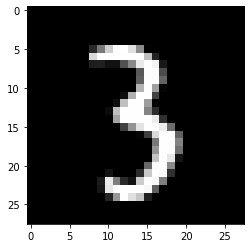

In [8]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [9]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 3
Ground truth is : 3


In [10]:
PATH_TO_MODEL = "./convnet.pth"
torch.save(model.state_dict(), PATH_TO_MODEL)

In [11]:
classes = range(10)

In [12]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [13]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

In [14]:
model.eval()

ConvNet(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout2d(p=0.1, inplace=False)
  (dp2): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [36]:
ind = 3

ip = images[ind].unsqueeze(0)
ip.requires_grad = True

In [37]:
def attribute_image_features(algorithm, ip, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(ip,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [38]:
saliency = Saliency(model)
grads = saliency.attribute(ip, target=labels[ind].item())
grads = np.reshape(grads.squeeze().cpu().detach().numpy(), (28, 28, 1))

In [39]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, ip, baselines=ip * 0, return_convergence_delta=True)
attr_ig = np.reshape(attr_ig.squeeze().cpu().detach().numpy(), (28, 28, 1))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0554])


In [40]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, ip, baselines=ip * 0, nt_type='smoothgrad_sq',
                                      n_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [41]:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, ip, baselines=ip * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image
Predicted: 3  Probability: 1.0


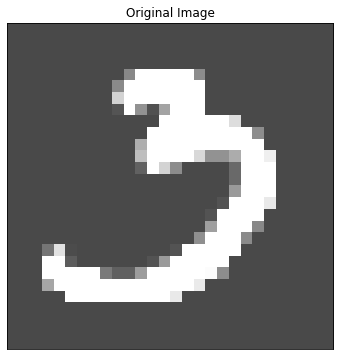

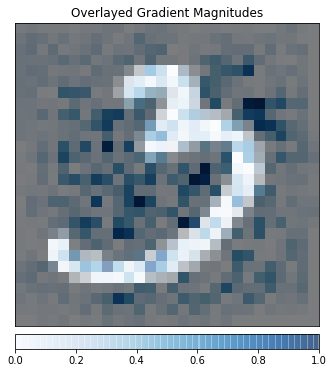

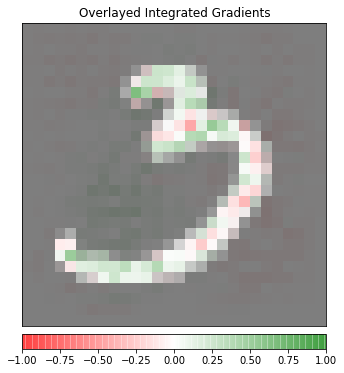

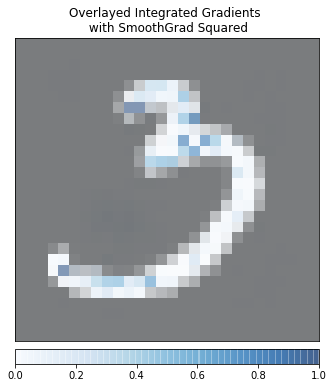

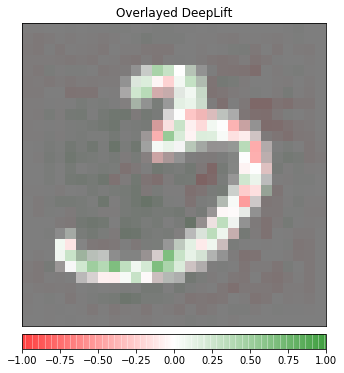

In [42]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.tile(np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)), (1,1,3))

_ = viz.visualize_image_attr(None, original_image, cmap='gray',
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")